## Цели и описание проекта

Описание проекта: **Оптимизация управления персоналом в компании "Работа с заботой"**

Компания "Работа с заботой" стремится улучшить управление персоналом, особенно в аспектах, связанных с удовлетворённостью сотрудников и прогнозированием их увольнений. HR-аналитики хотят использовать машинное обучение для более точного анализа, чтобы снизить вероятность внезапных увольнений и потерь для компании.

**Цель исследования:** Разработать модели для предсказания уровня удовлетворённости сотрудников и вероятности их увольнения. Эти прогнозы помогут выделить сотрудников с высоким риском ухода и выявить факторы, влияющие на их удовлетворённость, чтобы предоставить соответствующие рекомендации бизнесу.

**Ход исследования:**

1. **Загрузка данных:**
   Анализ данных из таблиц `train_job_satisfaction_rate.csv` (для предсказания удовлетворённости) и `train_quit.csv` (для предсказания увольнений), а также `test_features.csv` для тестирования моделей. Данные включают такие признаки, как отдел, уровень должности, загруженность, зарплата и длительность работы сотрудников.

2. **Предобработка данных:**
   Проверка на пропуски, дубликаты и корректность типов данных. При необходимости – заполнение пропусков и приведение данных к стандартному формату.

3. **Исследовательский анализ данных:**
   Изучение признаков, анализ их распределения и взаимосвязей, выявление сильных и слабых сторон данных. Построение профиля "рискового" сотрудника (например, вероятность увольнения по отделам или уровням загруженности).

4. **Подготовка данных для моделей:**
   Создание пайплайна для подготовки признаков, включающего кодирование категориальных признаков и масштабирование количественных. Применение различных методов кодирования для оптимальной работы моделей.

5. **Обучение моделей:**
   - Задача 1 (предсказание уровня удовлетворённости): Обучение как минимум двух моделей, включая линейную (например, `LinearRegression`) и дерево решений (`DecisionTreeRegressor`). Подбор гиперпараметров и оценка качества моделей с помощью метрики SMAPE.
   - Задача 2 (предсказание увольнения): Обучение не менее трёх моделей, включая линейные и нелинейные методы, и оценка их с помощью ROC-AUC. Выбор наилучшей модели и анализ её характеристик.


**Выводы и рекомендации приведены в конце проекта**

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка и изучение данных

In [ ]:
!pip install phik shap -q
!pip install -U shap matplotlib seaborn -q
!pip install --upgrade scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score,  recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [ ]:
df_train = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', index_col='id')
df_train.head()


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [ ]:
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', index_col='id')
test_target.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


In [ ]:
df_test = test_features.merge(test_target, on='id', how='outer')
df_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


#### Вывод по разделу
- подготовлены необходимые библиотеки для анализа данных и машинного обучения.

- загружены обучающая и тестовая выборки из внешних источников.
- обучающая выборка (df_train) содержит целевой признак job_satisfaction_rate, который отражает уровень удовлетворенности сотрудников.
- тестовая выборка разбита на test_features (признаки) и test_target (целевая переменная). Данные были объединены в один DataFrame df_test для дальнейшего анализа.

- проведена первичная проверка на корректность данных, наличие пропусков и общее понимание структуры признаков.

### Предобработка данных

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [ ]:
df_train = df_train.dropna()
df_train.isna().sum()

dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

- Обнаружены пропуски принято решение их удалить, так как незначительное количество
- Изменений типов данных не требуется

In [ ]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


In [ ]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


In [ ]:
cat_columns = df_train.select_dtypes(include=['object'])
for col in cat_columns:
  print(col, ':', df_train[col].unique())

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing']
level : ['junior' 'middle' 'sinior']
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


In [ ]:
for col in cat_columns:
  print(col, ':', df_test[col].unique())

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


In [ ]:
df_test.replace(' ', np.nan, inplace=True)

- Неявных дублей не обнаружено, при этом обнаружен в признаке dept значение " ", заменено на Nan
- пропуски будем в пайплане заполнять

In [ ]:
df_train.duplicated().sum()

245

In [ ]:
df_train.drop_duplicates().shape

(3745, 9)

#### Выводы по разделу Предобработка данных
- Обнаружены пропуски df_train принято решение их удалить, так как незначительное количество
- Изменений типов данных в данных не требуется
- Неявных дублей не обнаружено, при этом обнаружен в признаке dept значение " ", заменено на Nan
- пропуски принято решение заполнять в пайплане
- Полные дубли удалены в  df_train
- в df_test дубли не тронуты

### Исследовательский анализ данных

In [ ]:
df_train.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3990.000000,3990.000000,3990.000000,3990.000000
mean,3.722055,3.475188,33953.383459,0.533772
std,2.543715,1.009238,14907.247698,0.225353
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


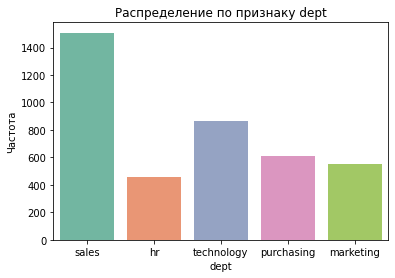

sales         0.377945
technology    0.217043
purchasing    0.152882
marketing     0.137845
hr            0.114286
Name: dept, dtype: float64


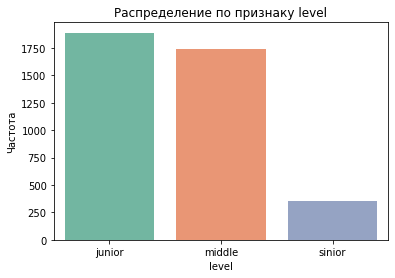

junior    0.473183
middle    0.437093
sinior    0.089724
Name: level, dtype: float64


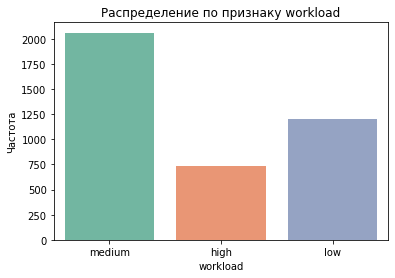

medium    0.516291
low       0.300000
high      0.183709
Name: workload, dtype: float64


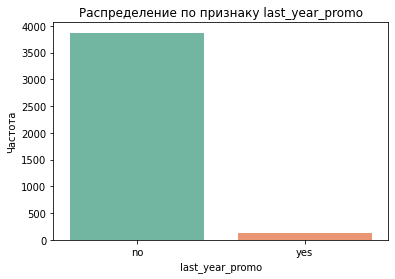

no     0.969925
yes    0.030075
Name: last_year_promo, dtype: float64


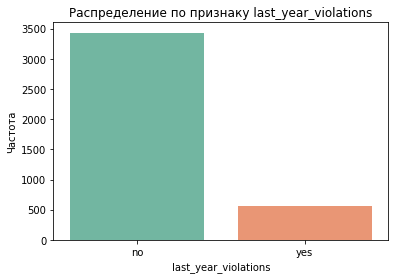

no     0.86015
yes    0.13985
Name: last_year_violations, dtype: float64


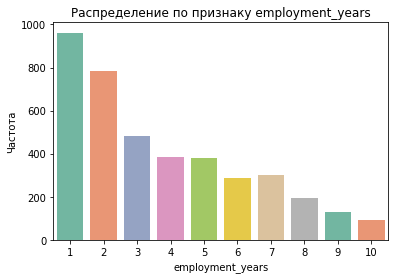

1     0.240852
2     0.196742
3     0.120301
4     0.095990
5     0.094987
7     0.075439
6     0.071930
8     0.048371
9     0.032581
10    0.022807
Name: employment_years, dtype: float64


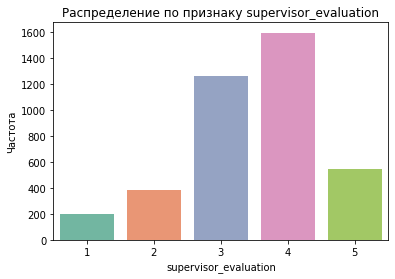

4    0.400251
3    0.316040
5    0.136341
2    0.096992
1    0.050376
Name: supervisor_evaluation, dtype: float64


In [ ]:
cat_columns = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'employment_years',
    'supervisor_evaluation',
]

def show_bar(data, cat_columns=None):
    if cat_columns is None:
        cat_columns = data.select_dtypes(include=['category', 'object'])

    for column in cat_columns:

        sns.countplot(x=column, data=data, palette='Set2', hue=column, legend=False);
        plt.title('Распределение по признаку '+ column)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()
        print(data[column].value_counts(normalize=True));

show_bar(df_train, cat_columns)


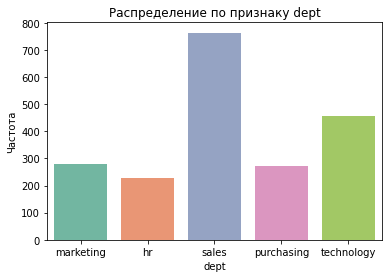

sales         0.382073
technology    0.227842
marketing     0.139710
purchasing    0.136705
hr            0.113671
Name: dept, dtype: float64


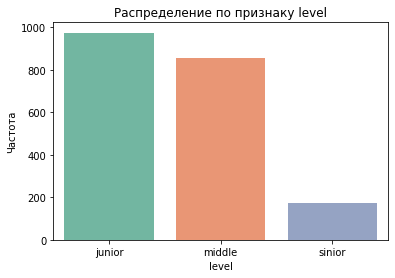

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64


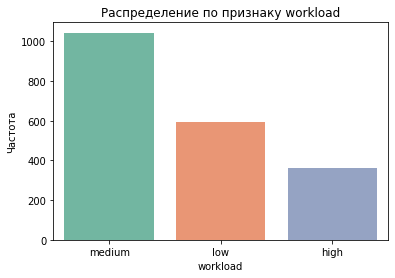

medium    0.521761
low       0.296648
high      0.181591
Name: workload, dtype: float64


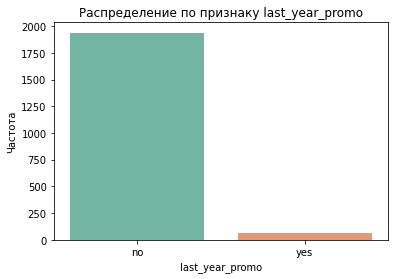

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64


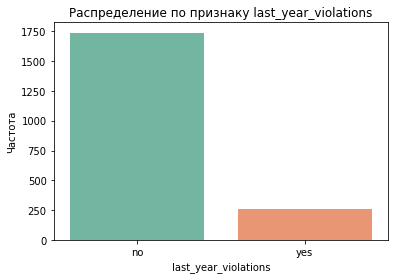

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64


In [ ]:
show_bar(df_test)

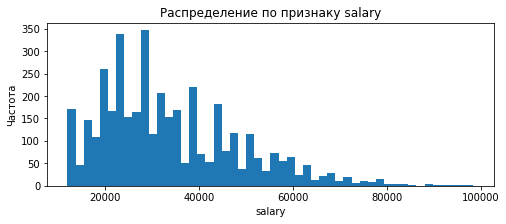

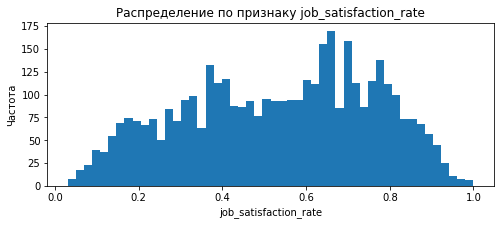

In [ ]:
num_columns = [
    'salary',
    'job_satisfaction_rate'
]

def show_hist(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float'])

    for column in num_columns:
        data[column].plot(kind='hist', bins=50, figsize=(8,3))
        plt.title('Распределение по признаку '+ column)
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()

show_hist(df_train, num_columns=num_columns)

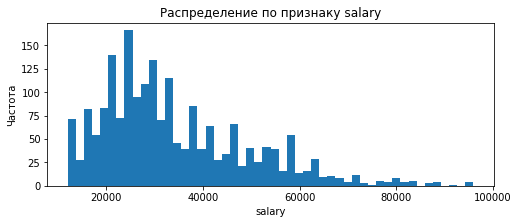

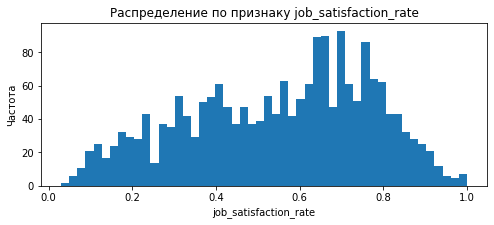

In [ ]:
show_hist(df_test, num_columns=num_columns)

Количественные признаки имеют нормальное распределение

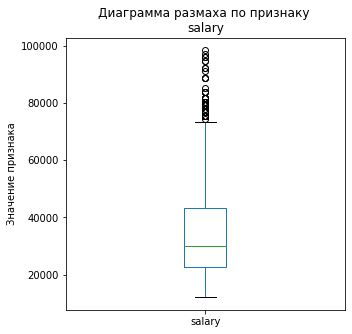

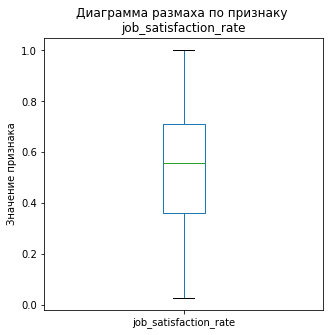

In [ ]:
def show_box(data, num_columns=None):
    if num_columns is None:
        num_columns = data.select_dtypes(include=['int', 'float'])

    for column in num_columns:
        data[column].plot(kind='box', figsize=(5,5));
        plt.title('Диаграмма размаха по признаку \n'+ column)
        plt.ylabel('Значение признака')
        plt.show()

show_box(df_train, num_columns=num_columns)

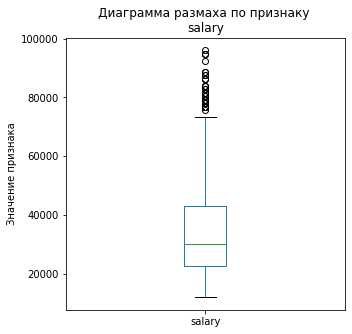

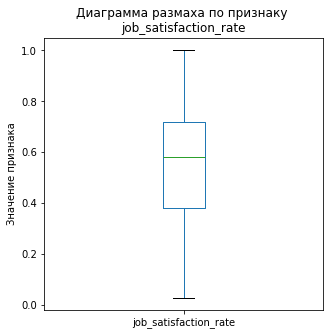

In [ ]:
show_box(df_test, num_columns=num_columns)

Наблюдаются выбросы в признаке salary, принято решение оставить как-есть.

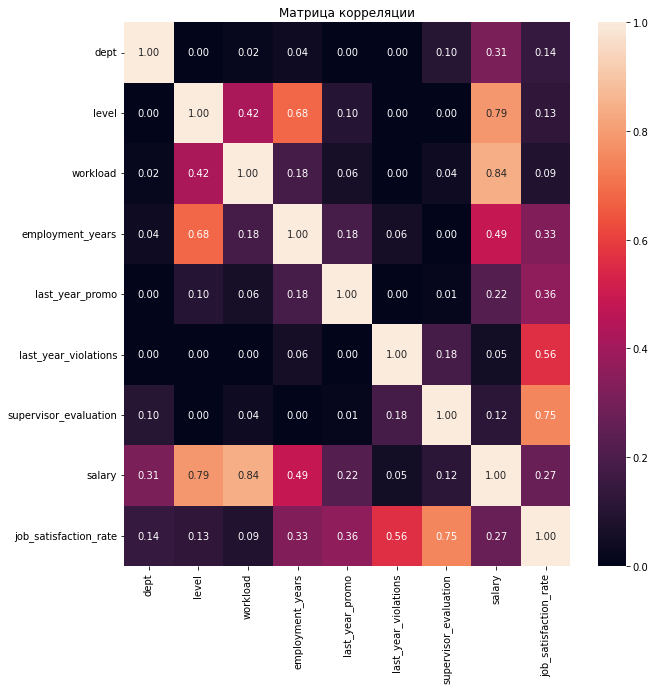

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train.phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

Мультиколинеарности признаков не наблюдается

#### Выводы по разделу Исследовательский анализ данных

- Преобладают сотрудники в отделах продаж и технологий

- Большая часть сотрудников находится на начальных уровнях: Примерно 47,3% сотрудников занимают позиции начального уровня, а 43,7% — среднего уровня.

- Загруженность сотрудников: Большинство сотрудников имеют среднюю загруженность (51,6%), в то время как 30% работают с низкой загруженностью, и лишь 18,3% — с высокой.

- Редкие повышения и нарушения в течение последнего года: Лишь 3% сотрудников получили повышение за последний год, что может свидетельствовать о строгих критериях повышения. Также лишь 13,9% имели нарушения, что говорит о высоком уровне дисциплины среди сотрудников.

- Большинство сотрудников с краткосрочным стажем: Около 45% сотрудников работают менее 2 лет, что может свидетельствовать о высокой текучести кадров или найме большого количества новых сотрудников.

- На удовлетворенность работой не сильно влияют такие признаки как отдел в котором работает сотрудник, загруженность уровень должности, при этом наблюдается сильная корреляция с признаками нарушение в предыдущий период, оценка работодателя, количество лет работы, и повышение в предыдущий год.

- мультиколлинерности признаков не наблюдается

### Подготовка данных и обучение моделей

In [ ]:
X_train = df_train.drop(['job_satisfaction_rate'], axis=1)
y_train = df_train['job_satisfaction_rate']
X_test = df_test.drop(['job_satisfaction_rate'], axis=1)
y_test = df_test['job_satisfaction_rate']

In [ ]:
ohe_columns = [
    'dept',
    'last_year_promo',
    'last_year_violations',
    ]
ord_columns = [
    'level',
    'workload',
    ]
num_columns = [
    'employment_years',
    'salary',
    'supervisor_evaluation',
    ]

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    # ['no', 'yes'],
                    # ['no', 'yes'],
                    # [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler() , num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 50),
        'models__max_features': range(5, 50),
        'models__max_leaf_nodes': range(5, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Словарь для модели LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Словарь для модели SVR
    {
        'models': [SVR()],
        'models__C': [0.1, 1.0, 10.0, 100.0],
        'models__epsilon': [0.01, 0.1, 1.0],
        'models__kernel': ['rbf', 'linear'],
        'models__degree':  range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    det = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_scorer = np.mean(np.abs(y_true - y_pred) / det) * 100
    return smape_scorer

smape_scorer = make_scorer(smape, greater_is_better=False)

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    # n_iter=20
)

In [ ]:
randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
4,1,SVR(),-14.727758,"{'preprocessor__num': StandardScaler(), 'model..."
6,2,DecisionTreeRegressor(random_state=42),-15.018982,"{'preprocessor__num': StandardScaler(), 'model..."
1,3,DecisionTreeRegressor(random_state=42),-15.126491,"{'preprocessor__num': StandardScaler(), 'model..."
7,4,DecisionTreeRegressor(random_state=42),-15.288993,"{'preprocessor__num': 'passthrough', 'models__..."
9,4,DecisionTreeRegressor(random_state=42),-15.288993,"{'preprocessor__num': 'passthrough', 'models__..."
3,6,DecisionTreeRegressor(random_state=42),-15.291737,"{'preprocessor__num': StandardScaler(), 'model..."
8,6,DecisionTreeRegressor(random_state=42),-15.291737,"{'preprocessor__num': StandardScaler(), 'model..."
0,8,DecisionTreeRegressor(random_state=42),-15.439182,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,9,DecisionTreeRegressor(random_state=42),-15.691200,"{'preprocessor__num': StandardScaler(), 'model..."
2,10,SVR(),-39.595508,"{'preprocessor__num': 'passthrough', 'models__..."


In [ ]:
y_pred = pd.DataFrame(best_model.predict(X_test))
y_test = pd.DataFrame(y_test)
smape(y_test, y_pred)

13.747196369111498

Лучшая модель выдает результат по метрике smape<15.

## Общий вывод по задаче 1
- По результатам кросс-валидации лучшей моделью оказалась модель SVR, Основные причины:
  - в данных есть нелинейная зависимость. SVR хорошо улавливает
  - SVR хорошо работает с выбросам, например в признаке оплата труда
- при этом 2-9 места по метрике smape заняла DecisionTreeRegressor, которая также хорошо улавливает нелинейные зависимости


## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка и изучение данных

In [ ]:
df_train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', index_col='id')
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [ ]:
test_features_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
test_features_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [ ]:
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', index_col='id')
test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [ ]:
df_test_quit = test_features_quit.merge(df_test['job_satisfaction_rate'], on='id').merge(test_target_quit, on='id')
df_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


#### Вывод по разделу
- загружены обучающая и тестовая выборки из внешних источников.
- обучающая выборка (df_train_quit) содержит целевой признак quit, который отражает факт увольнения сотрудника.
- тестовая выборка разбита на test_features_quit (признаки) и test_target_quit (целевая переменная). Данные были объединены в один DataFrame df_test_quit для дальнейшего анализа.
- проведена первичная проверка на корректность данных, наличие пропусков и общее понимание структуры признаков.

### Предобработка данных

In [ ]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [ ]:
df_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1998 non-null   object 
 1   level                  1999 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
 9   quit                   2000 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 171.9+ KB


In [ ]:
cat_columns = df_train_quit.select_dtypes(include=['object'])
for col in cat_columns:
  print(col, ':', df_train_quit[col].unique())

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level : ['middle' 'junior' 'sinior']
workload : ['high' 'medium' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']
quit : ['no' 'yes']


In [ ]:
cat_columns = df_test_quit.select_dtypes(include=['object'])
for col in cat_columns:
  print(col, ':', df_test_quit[col].unique())

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']
quit : ['no' 'yes']


In [ ]:
df_test_quit.replace(' ', np.nan, inplace=True)

Неявных дублей нет, заменены " " на Nan

In [ ]:
df_train_quit.duplicated().sum()

1413

In [ ]:
df_train_quit = df_train_quit.drop_duplicates()
df_train_quit.duplicated().sum()

0

#### Выводы по разделу Предобработка данных
- Обнаружены пропуски df_train принято решение их удалить
- Изменений типов данных в данных не требуется
- Неявных дублей не обнаружено, при этом обнаружен в признаке dept значение " ", заменено на Nan
- пропуски принято решение заполнять в пайплане
- Полные дубли удалены в  df_train
- в df_test дубли не тронуты

### Исследовательский анализ данных

In [ ]:
df_train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


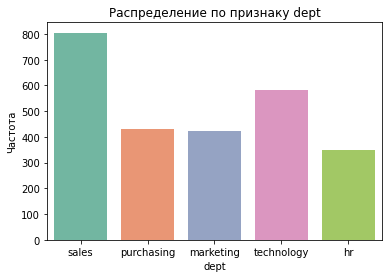

sales         0.311171
technology    0.224584
purchasing    0.166216
marketing     0.163510
hr            0.134519
Name: dept, dtype: float64


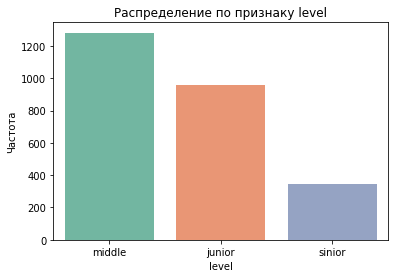

middle    0.495555
junior    0.370313
sinior    0.134132
Name: level, dtype: float64


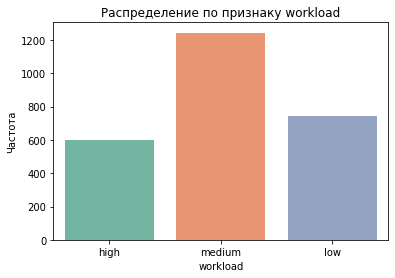

medium    0.480866
low       0.288365
high      0.230769
Name: workload, dtype: float64


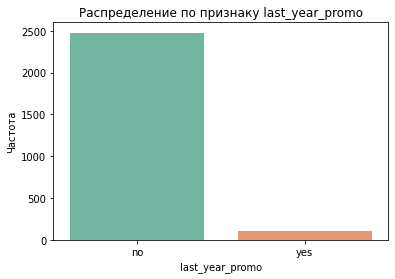

no     0.957093
yes    0.042907
Name: last_year_promo, dtype: float64


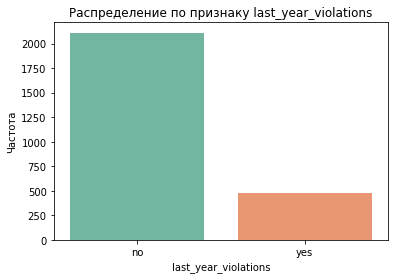

no     0.816003
yes    0.183997
Name: last_year_violations, dtype: float64


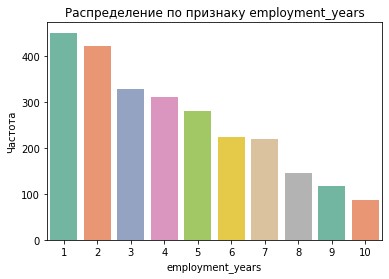

1     0.174333
2     0.163123
3     0.127174
4     0.120216
5     0.108233
6     0.086587
7     0.085041
8     0.056436
9     0.045613
10    0.033243
Name: employment_years, dtype: float64


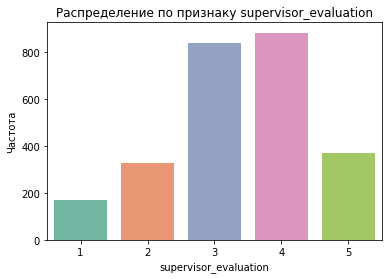

4    0.340935
3    0.324314
5    0.142636
2    0.126015
1    0.066100
Name: supervisor_evaluation, dtype: float64


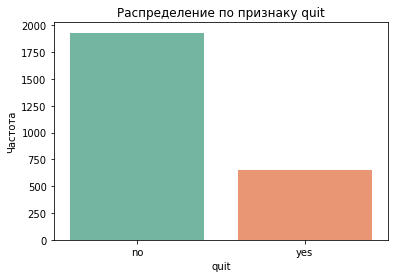

no     0.746811
yes    0.253189
Name: quit, dtype: float64


In [ ]:
cat_columns = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'employment_years',
    'supervisor_evaluation',
    'quit'
]

num_columns= [
    'salary'
]

show_bar(df_train_quit, cat_columns=cat_columns)

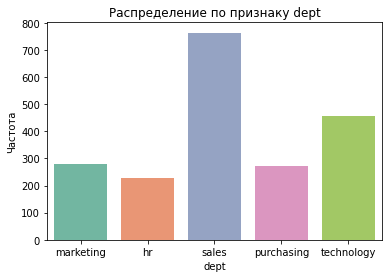

sales         0.382073
technology    0.227842
marketing     0.139710
purchasing    0.136705
hr            0.113671
Name: dept, dtype: float64


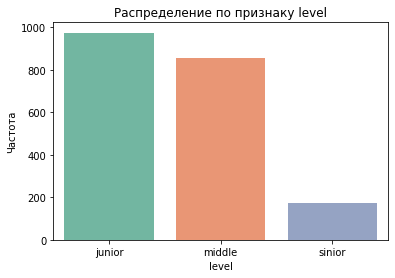

junior    0.487244
middle    0.427214
sinior    0.085543
Name: level, dtype: float64


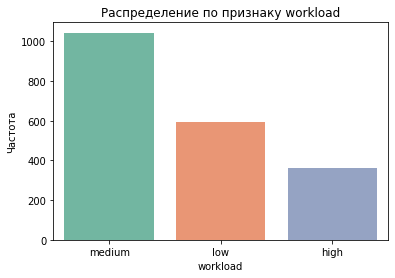

medium    0.521761
low       0.296648
high      0.181591
Name: workload, dtype: float64


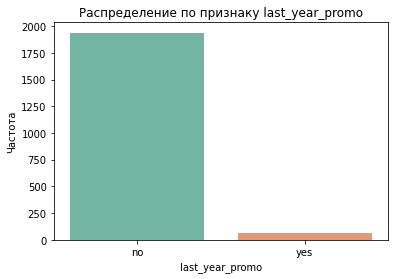

no     0.9685
yes    0.0315
Name: last_year_promo, dtype: float64


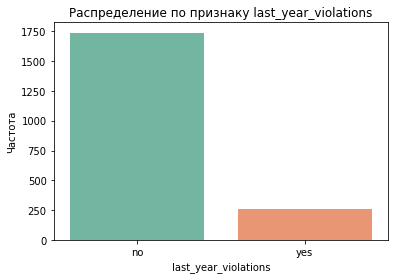

no     0.869
yes    0.131
Name: last_year_violations, dtype: float64


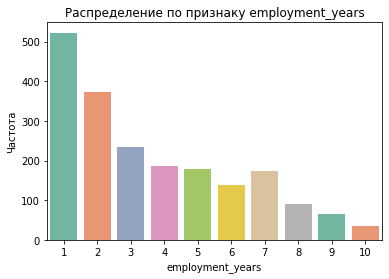

1     0.2610
2     0.1870
3     0.1170
4     0.0935
5     0.0895
7     0.0870
6     0.0690
8     0.0455
9     0.0330
10    0.0175
Name: employment_years, dtype: float64


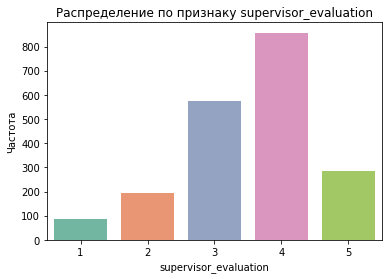

4    0.4285
3    0.2875
5    0.1420
2    0.0980
1    0.0440
Name: supervisor_evaluation, dtype: float64


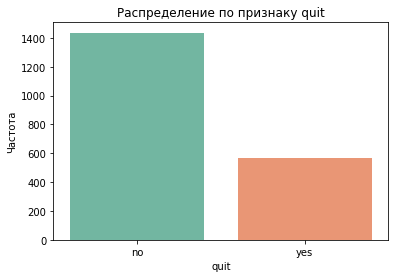

no     0.718
yes    0.282
Name: quit, dtype: float64


In [ ]:
show_bar(df_test_quit, cat_columns)

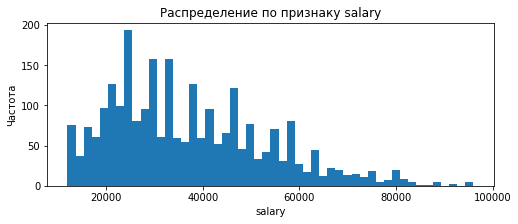

In [ ]:
show_hist(df_train_quit, num_columns=num_columns)

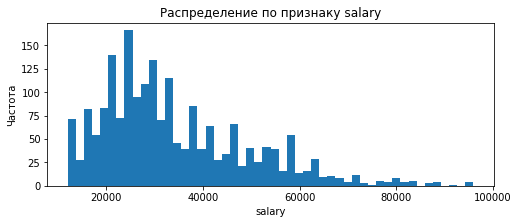

In [ ]:
show_hist(df_test_quit, num_columns=num_columns)

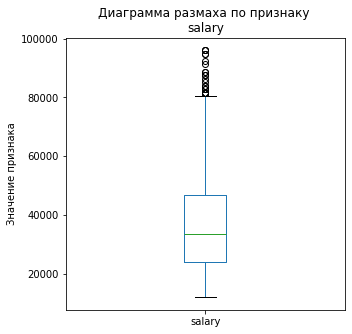

In [ ]:
show_box(df_train_quit, num_columns=num_columns)

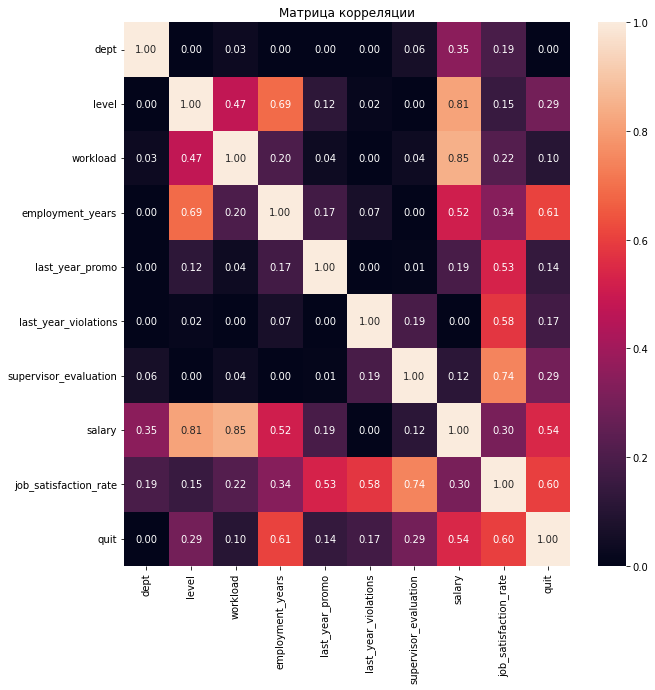

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_test_quit.phik_matrix(interval_cols=num_columns, bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

Мультиколлениарных признаков в тестовой выборке нет

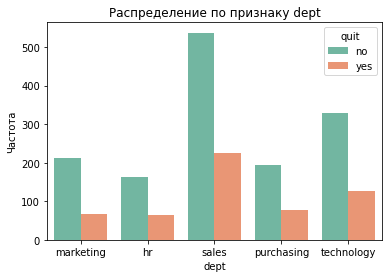

dept
hr            0.286344
marketing     0.240143
purchasing    0.285714
sales         0.296199
technology    0.279121
Name: quit_num, dtype: float64


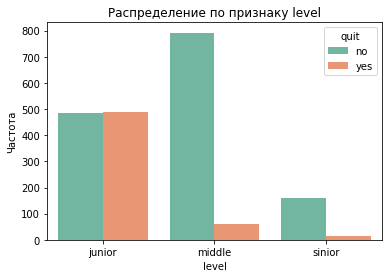

level
junior    0.501027
middle    0.072600
sinior    0.076023
Name: quit_num, dtype: float64


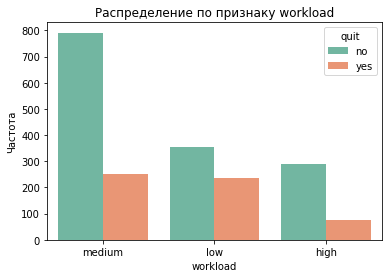

workload
high      0.206612
low       0.399663
medium    0.241611
Name: quit_num, dtype: float64


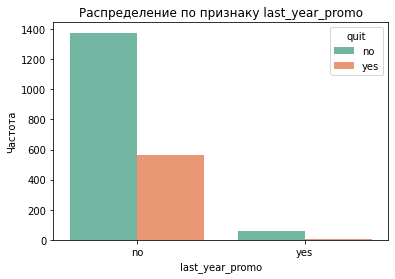

last_year_promo
no     0.289623
yes    0.047619
Name: quit_num, dtype: float64


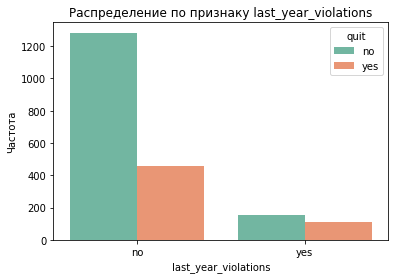

last_year_violations
no     0.261795
yes    0.416031
Name: quit_num, dtype: float64


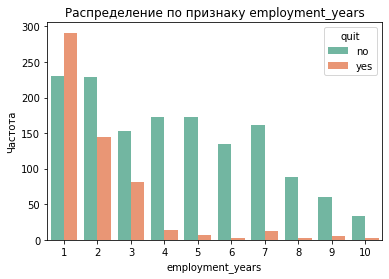

employment_years
1     0.557471
2     0.387701
3     0.346154
4     0.074866
5     0.039106
6     0.021739
7     0.074713
8     0.021978
9     0.090909
10    0.057143
Name: quit_num, dtype: float64


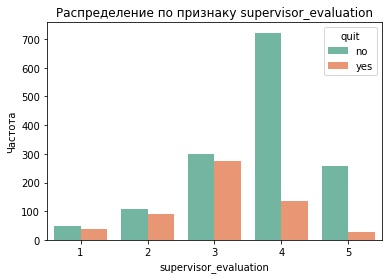

supervisor_evaluation
1    0.431818
2    0.454082
3    0.478261
4    0.157526
5    0.095070
Name: quit_num, dtype: float64


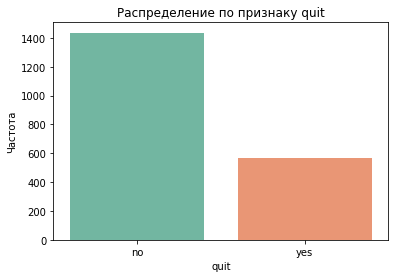

quit
no     0
yes    1
Name: quit_num, dtype: int64


In [ ]:
df_test_quit['quit_num'] = df_test_quit['quit'].apply(lambda x: 1 if x == 'yes' else 0)

for column in cat_columns:
    sns.countplot(x=column, data=df_test_quit, palette='Set2', hue='quit');
    plt.title('Распределение по признаку '+ column)
    plt.xlabel(column)
    plt.ylabel('Частота')
    plt.show()
    print( df_test_quit.groupby(column)['quit_num'].mean())


In [ ]:
df_test_quit.groupby('quit')['salary'].mean()

quit
no     37645.403900
yes    24955.319149
Name: salary, dtype: float64

In [ ]:
df_test_quit.drop('quit_num', axis=1, inplace=True)

Портрет «уволившегося сотрудника»:
- Отдел: Среди увольняющихся сотрудников нет явных различий по отделам

- Уровень должности: Наибольший процент увольняющихся сотрудников приходится на должности уровня junior (50%).

- Рабочая нагрузка: Сотрудники с низкой (40%) и средней (24%) нагрузкой чаще увольняются, чем те, у кого высокая нагрузка (20%).

- Продвижение за последний год: Только 5% сотрудников, получивших продвижение, уволились, что свидетельствует о том, что наличие продвижений способствует снижению текучести. Большая часть увольняющихся (29%) — это сотрудники, не получившие повышения.

- Нарушения за последний год: Наличие нарушений коррелирует с увольнением: 42% сотрудников с нарушениями покинули компанию, тогда как среди не имеющих нарушений — только 26%. Это может говорить о негативной корреляции между соблюдением дисциплины и желанием остаться в компании.

- Стаж работы: Сотрудники с наименьшим стажем (1–3 года) более склонны к увольнению, особенно те, кто работает в компании один год (56%). Текучесть снижается среди сотрудников с большим стажем, указывая на важность удержания новых сотрудников в первые годы.

- Оценка руководителей: Сотрудники с низкими оценками (1 и 2) чаще увольняются (43% и 45% соответственно). Это может свидетельствовать о низком уровне удовлетворенности или отсутствии карьерного роста у сотрудников с неудовлетворительной оценкой их работы.

In [ ]:
df_train_quit['job_satisfaction_rate'] = best_model.predict(df_train_quit)
df_train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.576720
814010,sales,junior,medium,2,no,no,4,27600,no,0.827935
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.322939
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.260841
910140,marketing,junior,medium,2,no,no,5,25200,no,0.716662
...,...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes,0.818664
106936,marketing,junior,low,1,no,no,5,18000,no,0.787853
775320,technology,junior,high,1,no,no,4,42000,yes,0.586473


interval columns not set, guessing: ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


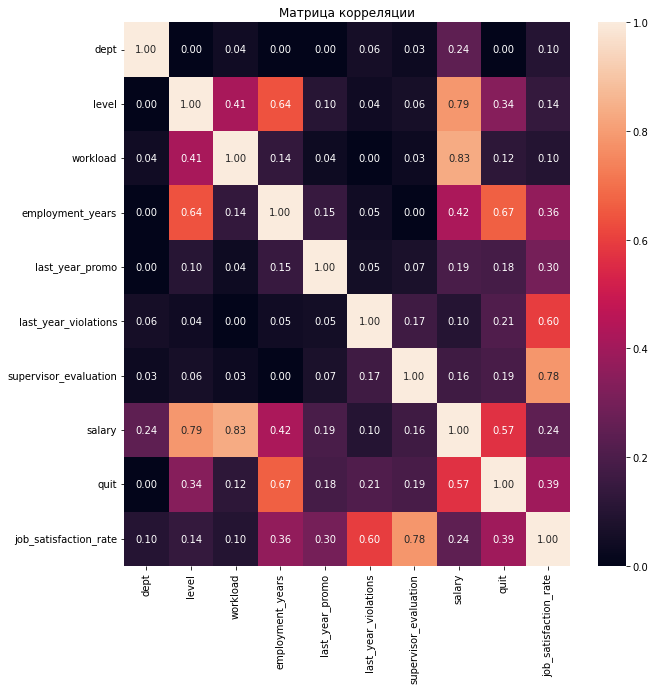

In [ ]:
plt.figure(figsize=(10, 10))

sns.heatmap(df_train_quit.phik_matrix(interval_cols=num_columns.append('job_satisfaction_rate'), bins=20), annot=True, fmt='.2f');
plt.title('Матрица корреляции')
plt.show()

- признак отдела не сильно влияет на таргет увольнение
- таргет увольнение сильно коррелирует с количеством лет работы в компании, с зарплатой, и удовлетворенностью на работе
- мультиколлениарных признаков не обнаружено

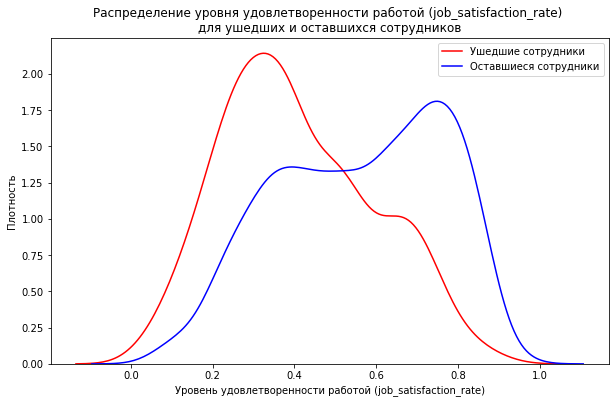

In [ ]:
quit_employees = df_train_quit[df_train_quit['quit'] == 'yes']['job_satisfaction_rate']
stay_employees = df_train_quit[df_train_quit['quit'] == 'no']['job_satisfaction_rate']

plt.figure(figsize=(10, 6))
sns.kdeplot(quit_employees,  color='red', label='Ушедшие сотрудники' )
sns.kdeplot(stay_employees,  color='blue', label='Оставшиеся сотрудники')


plt.title("Распределение уровня удовлетворенности работой (job_satisfaction_rate) \nдля ушедших и оставшихся сотрудников")
plt.xlabel("Уровень удовлетворенности работой (job_satisfaction_rate)")
plt.ylabel("Плотность")
plt.legend()
plt.show()

In [ ]:
quit_employees.describe()

count    655.000000
mean       0.407920
std        0.186474
min        0.017994
25%        0.267860
50%        0.380929
75%        0.538191
max        0.912009
Name: job_satisfaction_rate, dtype: float64

In [ ]:
stay_employees.describe()

count    1932.000000
mean        0.560488
std         0.204352
min         0.038923
25%         0.390694
50%         0.579447
75%         0.737321
max         0.971810
Name: job_satisfaction_rate, dtype: float64

Ушедшие сотрудники имеют уровень удовлетворенности работой в диапазоне примерно от 0,2 до 0,4. Сотрудники, которые остались, в основном имеют уровень удовлетворенности около 0,8, хотя среди них есть группа с уровнем удовлетворенности в диапазоне 0,4–0,6. Эта группа нуждается в дополнительном внимании, чтобы избежать риска их перехода в категорию ушедших сотрудников.

### Подготовка данных и обучение модели

In [ ]:
drop_columns = [
    'quit',
    'dept',
#     'level',
#     'last_year_promo',
#     'workload',
#     'job_satisfaction_rate',
    ]
X_train = df_train_quit.drop(drop_columns, axis=1)
y_train = df_train_quit['quit']
X_test = df_test_quit.drop(drop_columns, axis=1)
y_test = df_test_quit['quit']

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

category_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(category_mapping)

{0: 'no', 1: 'yes'}


In [ ]:
ohe_columns = [
    # 'dept',
    'last_year_promo',
    'last_year_violations',
    ]
ord_columns = [
    'level',
    'workload',
    'employment_years',
    'supervisor_evaluation',
    ]
num_columns = [
    'salary',

    'job_satisfaction_rate',
    ]

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high'],
                    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    # ['no', 'yes'],
                    # ['no', 'yes'],
                    [1, 2, 3, 4, 5],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler() , num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 50),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
#             max_iter=100,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'models__solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50
)


randomized_search.fit(X_train, y_train)

best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_);
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_);

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                           

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)

,rank_test_score,param_models,mean_test_score,params
30,1,KNeighborsClassifier(),0.905348,"{'preprocessor__num': StandardScaler(), 'model..."
9,2,KNeighborsClassifier(),0.905084,"{'preprocessor__num': MinMaxScaler(), 'models_..."
36,3,KNeighborsClassifier(),0.903252,"{'preprocessor__num': StandardScaler(), 'model..."
12,4,"LogisticRegression(penalty='l1', random_state=...",0.902615,"{'preprocessor__num': StandardScaler(), 'model..."
44,5,"LogisticRegression(penalty='l1', random_state=...",0.902359,"{'preprocessor__num': 'passthrough', 'models__..."
11,6,KNeighborsClassifier(),0.902107,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,7,"LogisticRegression(penalty='l1', random_state=...",0.901922,"{'preprocessor__num': MinMaxScaler(), 'models_..."
41,8,KNeighborsClassifier(),0.900739,"{'preprocessor__num': StandardScaler(), 'model..."
18,9,KNeighborsClassifier(),0.900222,"{'preprocessor__num': StandardScaler(), 'model..."
16,10,KNeighborsClassifier(),0.899855,"{'preprocessor__num': StandardScaler(), 'model..."


In [ ]:
y_pred_proba = pd.DataFrame(best_model.predict_proba(X_test)[:, 1])
roc_auc_score(y_test, y_pred_proba)

0.9241089067346253

## Общий вывод по проекту:

Цель проекта заключалась в разработке модели для прогнозирования вероятности увольнения сотрудников на основе различных факторов и уровня удовлетворенности сотрудников, таких как уровень должности, рабочая нагрузка, стаж работы, прошлогодние нарушения и продвижения, а также оценка руководства. В ходе исследования была проведена предобработка данных, корреляционный анализ, обучение нескольких моделей.

- **Предобработка и анализ данных** позволили выявить ключевые признаки, влияющие на увольнение, такие как уровень должности, рабочая нагрузка, нарушение дисциплины и оценка со стороны руководства.
- **Модели предсказания** показали, что увольнение чаще происходит среди сотрудников с низким уровнем должности (junior), с меньшим стажем работы, а также среди тех, кто не получил повышения и имеет нарушения. Наибольшая вероятность увольнения наблюдается среди сотрудников с низкими оценками со стороны руководства.


### Рекомендации компании:

1. **Удержание молодых специалистов (junior)**: Компания должна сосредоточить усилия на удержании сотрудников на начальных уровнях (junior), предоставляя им возможности для карьерного роста и развития. Нвапример программы наставничества, обучение и повышение квалификации.

2. **Рабочая нагрузка и удовлетворенность**: Сотрудники с низкой и средней нагрузкой чаще увольняются, что может свидетельствовать о недостатке интересных задач или недооценке их потенциала. Необходимо периодически пересматривать распределение нагрузки.

3. **Продвижение и карьера**: Невозможность карьерного роста — одна из причин увольнения. Важно, чтобы сотрудники видели перспективы для повышения и получения новых возможностей внутри компании. Это можно достичь через регулярные пересмотры карьерных планов и создание четкой стратегии продвижения.

4. **Управление нарушениями**: Важно обратить внимание на сотрудников, имеющих нарушения, так как они чаще увольняются. Компания должна активно работать над созданием конструктивной системы обратной связи и поддержания дисциплины, включая обучение сотрудников правилам и этике работы.

5. **Оценка работы сотрудников**: Проблемы с низкими оценками руководства могут быть связаны с отсутствием удовлетворенности работой. Рекомендуется регулярно проводить оценки сотрудников и предоставлять подробную обратную связь. В случае низких оценок важно выявлять причины и работать с сотрудниками для повышения их удовлетворенности и производительности.

6. **Фокус на удержание сотрудников с малым стажем**: Сотрудники с низким стажем работы (особенно 1–3 года) наиболее подвержены увольнению. Компания должна создать программы адаптации и менторства для новых сотрудников, чтобы они быстрее чувствовали себя частью команды и не искали возможности в других компаниях.

### Заключение:

Для уменьшения текучести и повышения удержания сотрудников, компании необходимо сфокусироваться на улучшении условий для начинающих сотрудников, улучшении карьерных перспектив, предоставлении более интересных и развивающих задач, а также активном управлении нарушениями и повышении оценки работы сотрудников. Эти меры помогут снизить вероятность увольнений и создать более стабильную и продуктивную рабочую атмосферу.

 <div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера (общий вывод по проекту) <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с этим проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии/ классификации и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались  функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использованы пайплайны, кросс-валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, я указал их в моих комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

    

</div>